<h1 align="center"> Using Template Subtraction and updating WCS in AutoPhoT </h1> 


This notebook will cover how to run AutoPhoT with template subtraction. Additional this notebook will explain now to setup AutoPhoT such that it can update an image's WCS automatically

To review the basic operations of AutoPHoT, see ([here](https://github.com/Astro-Sean/autophot/blob/master/example_notebooks/autophot_example.ipynb))



<div class="alert alert-info">
  <strong>info!</strong> For this notebook you will need HOTPANTS, PyZOGY and Astrometry.Net installed on your machine, for detailed installation instructions, see <a href=https://github.com/Astro-Sean/autophot>here</a>.
</div>


<div class="alert alert-danger">
  <strong>Advice</strong> Template subtraction can be a black box of pain and frustration. AutoPHoT works well when the template is from the same telescope and instrument, with varying results if there is discrepancy from where the template and image are from. Check all template subtracted images!
</div>


As before we will load in the autophot control file - we will need to update a few options to prepare AutoPhot for template subtractions


In [1]:
from autophot.prep_input import load
autophot_input = load()

Default input loaded in from: 
/Users/seanbrennan/miniconda3/envs/autophot/lib/python3.7/site-packages/autophot/databases/default_input.yml


<h2 align="center">Loading in some example Data</h2> 
In this example we will use the function below with *template_subtraction_example = True* to create a new folder on your Desktop called *autophot_template_subtrction_example*. 

<div class="alert alert-warning">
  <strong>Warning!</strong> If you are using your own data and are familiar with the directory setup this cell is not needed.
</div>


In [2]:
from autophot.example import save_example_data
fpath = save_example_data.save_fits_to_desktop(template_subtraction_example = True) 

Successful copy of transient_with_host.fits written to: /Users/seanbrennan/Desktop/autophot_host_subtraction_example/transient_with_host.fits

Successful copy of template_with_host.fits written to: /Users/seanbrennan/Desktop/autophot_host_subtraction_example/templates/gp_template


The above function returns the file location, *fpath*, which is the filepath to our fits images. This image contained a transient that is heavily contaminated by it's host Galaxy. Additionally the function has created a folder named templates, In the cell below we can list out the contents of this directory we created.

In [3]:
import os

# Lets just see that everything is in place 
dirpath = os.path.dirname(fpath)

# List contents of folder. We use this generator function to ignore hidden files
dir_contents = [i for i in os.listdir(dirpath) if not i.startswith('.')]

print('\nlist of contects in: %s \n%s' % (dirpath,dir_contents))# returns list of folder contents


list of contects in: /Users/seanbrennan/Desktop/autophot_host_subtraction_example 
['templates', 'transient_with_host.fits']


<h2 align="center">Template Directory structure - Important</h2> 
Now we can check the contents of this *templates* fodler. In the cell below we list out the directory contents, we can see that there is a set of directories labeled X_template, where X is the name of the filter which AutoPHoT accepts, UBVRI, ugriz, and JHK bands.

<div class="alert alert-info">
  <strong>Info!</strong> Because of the case-sensitive name of Python 3, we've decided to allocate ugriz template folders name to have up, gp, rp, ip, and zp. See below.
</div>




In [4]:
main_template_foler = os.path.join(dirpath,'templates')

template_dir_contents = [i for i in os.listdir(main_template_foler) if not i.startswith('.')]

print('Contents of template folder:',template_dir_contents)
#os.listdir(main_template_foler)

Contents of template folder: ['B_template', 'I_template', 'H_template', 'V_template', 'ip_template', 'zp_template', 'gp_template', 'U_template', 'rp_template', 'J_template', 'K_template', 'R_template', 'up_template']


In this exmaple, the image and template are both in *g* band. We can check the contents of the *gp_template* directory

In [5]:
gp_template_folder = os.path.join(main_template_foler,'gp_template')

gp_template_dir_contents = [i for i in os.listdir(gp_template_folder) if not i.startswith('.')]

print('Contents of gp template folder:',gp_template_dir_contents )

Contents of gp template folder: ['template_with_host.fits']


<h2 align="center">Setting up AutoPHoT For template subtraction</h2> 


We will first set up AutoPHoT for template subtraction with HOTPANTS and then show the commands nessecary for template subtractions using ZOGY


<div class="alert alert-info">
  <strong>Info!</strong> In the following cell we set up AutoPHoT for basic execution, for details on this step see <a href=https://github.com/Astro-Sean/autophot/blob/master/example_notebooks/autophot_example.ipynb>here</a>.
</div>


In [6]:
# Location of our fits files
autophot_input['fits_dir'] = dirpath
print('Setting file directory (fits_dir) to: %s' % dirpath)

autophot_input['wdir'] = dirpath
print('Setting work directory (wdir) to: %s' % dirpath)

# set the catalog as before # Can choose skymapper, apass, pan_starrs, 2mass
autophot_input['catalog']['use_catalog'] = 'sdss'

Setting file directory (fits_dir) to: /Users/seanbrennan/Desktop/autophot_host_subtraction_example
Setting work directory (wdir) to: /Users/seanbrennan/Desktop/autophot_host_subtraction_example


Select our Target - in this example we are looking at AT 2018cow which is heaviliy contaminated by it's host galaxy, CGCG137-068

In [7]:
# Select a source and update our syntax input
# For this example lets use the location of AT2016jbu as that won't be removed in the template subtraction
ra  = 244.000917 
dec = 22.268031

from astropy.coordinates import SkyCoord 
c = SkyCoord(ra,dec , unit="deg") 


# Not tell autophot where to look
autophot_input['target_ra'] = c.ra.degree
autophot_input['target_dec'] = c.dec.degree

<h3 align="center">Why we need template subtraction in this case</h3> 

Below we will plot the general location of the transient. The plot shows that there is a lot of contamination from the host galaxy. This will lead to poor fitting and high errors on our target magnitude.

In this specific example AT 2018cow is contaminated by its host as well as a source south-west of its' locaiton

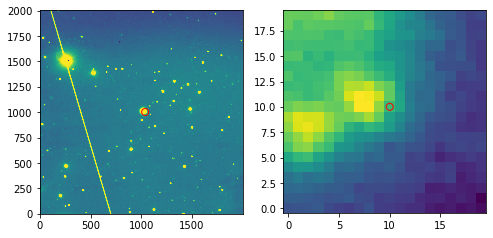

In [8]:
# We will plot out the image 
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize,SquaredStretch,ZScaleInterval


# autophot functions to find image data and header from fits files
from autophot.packages.functions import getimage
from autophot.packages.functions import getheader

# To retrieve the WCS information from this image
from astropy import wcs
from astropy.coordinates import SkyCoord 

# image
data = getimage(fpath)

# header
header = getheader(fpath)

# Create an ImageNormalize object
vmin,vmax = (ZScaleInterval(nsamples = 1000)).get_limits(data)

# WCS information of image
w = wcs.WCS(header)

# get pixel coordinates of this source
c = SkyCoord(ra,dec , unit="deg") 
x_pix,y_pix = w.all_world2pix(c.ra.degree, c.dec.degree, 1)


# plot image
fig = plt.figure(figsize = (8,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(data,
          vmin = vmin,
          vmax = vmax,
          origin = 'lower',
          cmap = 'viridis')

ax1.scatter(x_pix,y_pix,
            marker = 'o',
            facecolor = 'none',
            edgecolor = 'r',
            s = 50)

# Plot a close up cutout of the source too
cutout_size = 10
cutout = data[int(y_pix-cutout_size):int(y_pix+cutout_size),
              int(x_pix-cutout_size):int(x_pix+cutout_size)]

ax2.imshow(cutout,
           origin = 'lower',
           cmap = 'viridis')

ax2.scatter(cutout_size,cutout_size,
            marker = 'o',
            facecolor = 'none',
            edgecolor = 'r',
            s = 50)


plt.show()

<h3 align="center">Updating AutoPHoT commands</h3> 

AutoPHoT needs to be told where to find certain executables for Astrometry.net and HOTPANTS. For my machine they are as follows. See [here](https://github.com/Astro-Sean/autophot) for how to find these file paths on your machine.

In [9]:
# Location of solve-field executable for Astrometry.Net
autophot_input['wcs']['solve_field_exe_loc'] = '/usr/local/Cellar/astrometry-net/0.85_1/bin/solve-field'

# Location of  hotpants executable from HOTPANTS
autophot_input['template_subtraction']['hotpants_exe_loc'] = '/usr/local/hotpants-master/hotpants'

We also need to tell AutoPHoT that we want to perform image subtraction


In [10]:
autophot_input['template_subtraction']['do_subtraction'] = True

<h3 align="center">Preprosseing of Template images</h3> 

AutoPHoT includes a package to prep the template images for use. This includes redoing the WCS values, cleaning comsic rays and building a PSF model and saving it as a fits file. The later step is vital for using ZOGY with AutoPHoT.

In [11]:
autophot_input['template_subtraction']['prepare_templates'] = True

We can now execute AutoPHoT. This first execution will prepare our tenplate files


In [12]:
from autophot.autophot_main import run_automatic_autophot

run_automatic_autophot(autophot_input)


        _       _       ___ _  _    _____
       /_\ _  _| |_ ___| _ \ || |__|_   _|
      / _ \ || |  _/ _ \  _/ __ / _ \| |
     /_/ \_\_,_|\__\___/_| |_||_\___/|_|
    
     ---------------------------------------
        Automated Photometry of Transients
        S. J. Brennan et al. 2021 
        Please provide feedback/bugs to:
        Email: sean.brennan2@ucdconnect.ie
    ---------------------------------------
Directory of fits file: /Users/seanbrennan/Desktop/autophot_host_subtraction_example
Found Telescopes:

 - Liverpool Telescope
Adding new Telescope: Liverpool Telescope
Do you want to update location of Liverpool Telescope 
( Press enter for n ) 
( Accepted answers - y or n )
> n
-> n

 *** Instrument Found ***
Liverpool Telescope -> INSTRUME -> IO:O
Enter name of Telescope and Instrument for labelling 
( Press enter for Liverpool Telescope+IO:O ) 
> 
-> Liverpool Telescope+IO:O
Enter Pixel scale in arcsec/pixel 
( Press enter for 0.4 ) 
> 
-> 0.4

Cannot find any keywo

File: template_with_host.fits - PID: 19211
Start Time: 2022-02-10 13:44:29.398422
Filter keyoward used: FILTER
Write Directory: /Users/seanbrennan/Desktop/autophot_host_subtraction_example/templates/gp_template
Read noise key not found for template file
Read Noise: 0.0 [e^- /pixel]
Template GAIN: 1.0 [e^- /count]
Template Exposure Time: 4.0 [s]



+-------------------------+
|Preparing templates files|
+-------------------------+



Detecting/removing cosmic ray sources


Starting Astroscrappy ... 

Contaminated pixels with Cosmic rays removed: 76
Cosmic rays removed - image updated
ASTROMETRY started...
ASTROMETRY finished: 7s
Removing any pre-existing WCS keys 
Updating WCS keys with new values

Searching for FWHM
Using Gaussian Profile for fitting



+-------------------------------+
|Finding Full Width Half Maximum|
+-------------------------------+




Number of sources before cleaning [ 25.0 sigma ]: 25 
Updating search FWHM value


Updated guess for FWHM: 4.5 pixels 



Number of sources before cleaning [ 25.0 sigma ]: 87 
Removed 7 sources near boundary
Removed 11 crowded sources


Fitting source for FWHM: 69/69  

Removed 8 FWHM outliers
Removed 21 median outliers
Useable sources found [ 25 sigma ]: 69
Removes 0 sources within minimum seperation [ 22 pixel ]

Large error on FWHM - returning plots for user diagnostic
/Users/seanbrennan/miniconda3/envs/autophot/lib/python3.7/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/seanbrennan/miniconda3/envs/autophot/lib/python3.7/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)

FWHM: 4.823 +/- 2.196 [ pixels ]
Residual table updated: 1 / 10 
	SNR: 278 :: FWHM fitted 4.529
Residual table updated: 2 / 10 
	SNR: 259 :: FWHM fitted 4.396
Residual table updated: 3 / 10 
	SNR: 230 :: FWHM fitted 4.477



+-------------------------------------------+
|Building PSF model using stars in the field|
+-------------------------------------------+



Residual table updated: 4 / 10 
	SNR: 223 :: FWHM fitted 4.518
Residual table updated: 5 / 10 
	SNR: 188 :: FWHM fitted 4.484
Residual table updated: 6 / 10 
	SNR: 157 :: FWHM fitted 4.465
Residual table updated: 7 / 10 
	SNR: 155 :: FWHM fitted 4.435
Residual table updated: 8 / 10 
	SNR: 153 :: FWHM fitted 4.351
Residual table updated: 9 / 10 
	SNR: 144 :: FWHM fitted 4.427
Residual table updated: 10 / 10 
	SNR: 100 :: FWHM fitted 4.551

PSF built using 10 sources



PSF model saved as: /Users/seanbrennan/Desktop/autophot_host_subtraction_example/templates/gp_template/PSF_model_template_with_host.fits

------------------------------------------------------------
Templates ready - Please check to make sure they are correct
set 'prepare_templates' to False and execute
------------------------------------------------------------

DONE

Done - Time Taken: 37.3


<div class="alert alert-warning">
  <strong>Warning!</strong> Make sure to set autophot_input['template_subtraction']['prepare_templates'] to False afterwards
</div>

In [13]:
autophot_input['template_subtraction']['prepare_templates'] = False

We can list the contents of the gp_template folder to check out the new contents

In [14]:
gp_template_folder = os.path.join(main_template_foler,'gp_template')
gp_template_dir_contents = [i for i in os.listdir(gp_template_folder) if not i.startswith('.')]

print('Contents of gp template folder:',gp_template_dir_contents )

Contents of gp template folder: ['PSF_model_template_with_host.fits', 'template_with_host.fits', 'template_with_host.fits.log', 'template_with_host_astrometry.log', 'image_analysis_template_with_host.pdf', 'fwhm_histogram_template_with_host.pdf', 'calib_template.csv', 'image_analysis_template_with_host.csv']


<h2 align="center">Using HOTPANTS with AutoPHoT</h2> 

HOTPANTS is set to the default template subtraction method in AutoPHoT. Since we have updated the *hotpants_exe_loc* comamnd above we can simply run the AutoPHoT code again.

In [15]:
run_automatic_autophot(autophot_input)


        _       _       ___ _  _    _____
       /_\ _  _| |_ ___| _ \ || |__|_   _|
      / _ \ || |  _/ _ \  _/ __ / _ \| |
     /_/ \_\_,_|\__\___/_| |_||_\___/|_|
    
     ---------------------------------------
        Automated Photometry of Transients
        S. J. Brennan et al. 2021 
        Please provide feedback/bugs to:
        Email: sean.brennan2@ucdconnect.ie
    ---------------------------------------
Directory of fits file: /Users/seanbrennan/Desktop/autophot_host_subtraction_example



User instrument database: /Users/seanbrennan/Desktop/autophot_host_subtraction_example/telescope.yml

Number of files: 1

1 telescope(s) detected - checking header keywords



Found Telescopes:

 - Liverpool Telescope

-> Telescope check complete

Checking Filter keywords and database

-> Filter check complete

Checking Filter information for each image

Files removed - Wrong Image Type: 0

Files removed - No/Wrong filter(s): 0
Filters not included: []


Files removed: 0

+-----------+
|File: 1 / 1|
+-----------+



File: transient_with_host_APT.fits - PID: 19211
Start Time: 2022-02-10 13:44:53.394970
Filter keyoward used: FILTER
Telescope: Liverpool Telescope
Filter: g
MJD: 58346.923
Date of Observation : 2018-08-16
Read Noise: 0.0 [e^- /pixel]
GAIN: 1.0 [e^- /count]
Exposure time: 4 [s] 
Detecting/removing cosmic ray sources


Starting Astroscrappy ... 

Contaminated pixels with Cosmic rays removed: 296
Cosmic rays removed - image updated
Astrometry.net already excuted

Searching for FWHM
Using Gaussian Profile for fitting



+-------------------------------+
|Finding Full Width Half Maximum|
+-------------------------------+




Number of sources before cleaning [ 25.0 sigma ]: 25 
Updating search FWHM value


Updated guess for FWHM: 4.9 pixels 



Number of sources before cleaning [ 25.0 sigma ]: 84 
Removed 6 sources near boundary
Removed 12 crowded sources


Fitting source for FWHM: 66/66 

Removed 8 FWHM outliers
Removed 22 median outliers
Useable sources found [ 25 sigma ]: 66
Removes 0 sources within minimum seperation [ 24 pixel ]

Large error on FWHM - returning plots for user diagnostic
/Users/seanbrennan/miniconda3/envs/autophot/lib/python3.7/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/seanbrennan/miniconda3/envs/autophot/lib/python3.7/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)

FWHM: 5.173 +/- 2.238 [ pixels ]

Seeing: 1.568 [ arcsec ]
Aperture size: 8.8 pixels
Aperture correction: -0.031 +/- 0.017 [ mag ]
Searching for new catalog [sdss] for target_ra_244_dec_22 



+----------------------------------------------+
|Searching for catalog for target_ra_244_dec_22|
+----------------------------------------------+



Catalog length: 7958
Removed 7021 sources fainter than cutoff [20 mag]
Using Gaussian Profile for fitting
Catalog Length: 87



+---------------------------------+
|Matching catalog sources to image|
+---------------------------------+

Removed 595 sources too close to boundary or off image
Matching catalog to image: 81 / 87 :: Useful sources 80 / 87 


Median offset: 2.1 [ pixels ] / 0.6 [ arcsec ]


Matching catalog to image: 87 / 87 :: Useful sources 86 / 87   .. done

Broken cutouts: 0
Not in correct location: 0
Not detected: 1
Saturated: 0
Error: 0


+-------------------------------------------+
|Building PSF model using stars in the field|
+-------------------------------------------+



Residual table updated: 1 / 10 
	SNR: 293 :: FWHM fitted 4.990
Residual table updated: 2 / 10 
	SNR: 174 :: FWHM fitted 4.961
Residual table updated: 3 / 10 
	SNR: 169 :: FWHM fitted 4.898
Residual table updated: 4 / 10 
	SNR: 168 :: FWHM fitted 4.947
Residual table updated: 5 / 10 
	SNR: 157 :: FWHM fitted 4.975
Residual table updated: 6 / 10 
	SNR: 135 :: FWHM fitted 4.917
Residual table updated: 7 / 10 
	SNR: 102 :: FWHM fitted 4.934
Residual table updated: 8 / 10 
	SNR: 99 :: FWHM fitted 4.900
Residual table updated: 9 / 10 
	SNR: 94 :: FWHM fitted 4.945
Residual table updated: 10 / 10 
	SNR: 93 :: FWHM fitted 4.929

PSF built using 10 sources

Unity PSF: 29.9 [counts] 
Unity Residual table: 2.2 [counts] 
Using PSF Photometry on Sequence Stars
Approx PSF mag -11.307 mag


PSF model saved as: /Users/seanbrennan/Desktop/autophot_host_subtraction_example_REDUCED/transient_with_host/PSF_model_transient_with_host_APT.fits

+-------------------+
|Measuring PSF model|
+-------------------+


+-----------------------------------+
|Fitting PSF to sources in the image|
+-----------------------------------+

Fitting PSF to source: 85 / 86 

Input data contains invalid values (NaNs or infs), which were automatically clipped.

Mean g-band zeropoint: 27.918 +/- 0.024 



Fitting PSF to source: 86 / 86 
+-----------------------+
|Finding Zeropoint value|
+-----------------------+

Checking for suitable catalog sources
Removed 84 sources lower than SNR of 10.0


Looking for User template in /Users/seanbrennan/Desktop/autophot_host_subtraction_example/templates
Template filepath: /Users/seanbrennan/Desktop/autophot_host_subtraction_example/templates/gp_template/template_with_host.fits 
Aligning via WCS with reproject_interp
Template smaller than image, cropping to exlcude zeros
Trimmed template shape:(1957 1938)
Trimmed image shape:(1957 1938)

Image subtracion
Performing image subtraction using HOTPANTS
HOTPANTS finished: 26s
Subtraction saved as transient_with_host_APT_image_cutout_subtraction
Target photometry on subtracted image
Setting target background to zero in template subtraction image



+-----------------------------------------------+
|Performing PSF photometry on at target location|
+-----------------------------------------------+



Setting target background to zero in template subtraction image
Approximate Target SNR: 8.8
SNR = 9 - skipping limiting magnitude
Pixel Offset: 1.978
Limiting Magnitude: skipped
Target Detection probability: 99 %
Target flux: 477.110 +/- 16.275 [counts/s]
Noise: 439.153 [counts/s]
Target SNR: 8.841 +/- 0.116
Instrumental Magnitude: -6.697 +/- 0.065
Zeropoint: 27.918 +/- 0.024
Target Magnitude: 21.222 +/- 0.183 

*** Transient well detected ***

Time Taken [ 19211 ]: 87s
Sucess: transient_with_host_APT.fits :: PID 19211 



Error from multlocation [10] recovery: 0.054 [mag]

---

Files that failed : []

DONE

Done - Time Taken: 87.5


Lets check the host-subtracted image and transient location 

<div class="alert alert-success">
  <strong>Success!</strong> AT2018cow is now clearly seen with little/no contamination from any unwanted flux. 
</div>

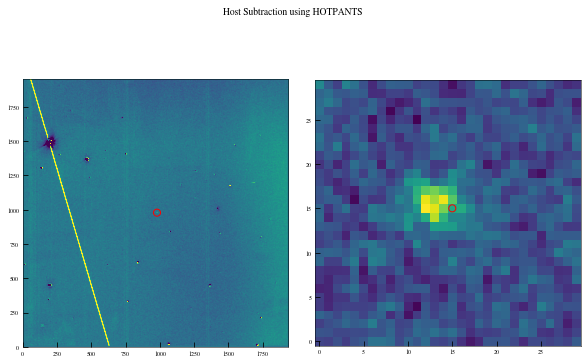

In [16]:
fname = os.path.basename(fpath)
output_dir = dirpath+'_REDUCED/'+fname.replace('.fits','')
host_subtracted_fpath = os.path.join(output_dir,fname.replace('.fits','_APT_image_cutout_subtraction.fits'))

# We will plot out the image 
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize,SquaredStretch,ZScaleInterval


# autophot functions to find image data and header from fits files
from autophot.packages.functions import getimage
from autophot.packages.functions import getheader

# To retrieve the WCS information from this image
from astropy import wcs
from astropy.coordinates import SkyCoord 

# image
data = getimage(host_subtracted_fpath)

# header
header = getheader(host_subtracted_fpath)

# Create an ImageNormalize object
vmin,vmax = (ZScaleInterval(nsamples = 1000)).get_limits(data)

# WCS information of image
w = wcs.WCS(header)

# get pixel coordinates of this source
c = SkyCoord(ra,dec , unit="deg") 
x_pix,y_pix = w.all_world2pix(c.ra.degree, c.dec.degree, 1)


# plot image
fig = plt.figure(figsize = (10,6))
fig.suptitle('Host Subtraction using HOTPANTS')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(data,
          vmin = vmin,
          vmax = vmax,
          origin = 'lower',
          cmap = 'viridis')

ax1.scatter(x_pix,y_pix,
            marker = 'o',
            facecolor = 'none',
            edgecolor = 'r',
            s = 50)

# Plot a close up cutout of the source too
cutout_size = 15
cutout = data[int(y_pix-cutout_size):int(y_pix+cutout_size),
              int(x_pix-cutout_size):int(x_pix+cutout_size)]

ax2.imshow(cutout,
           origin = 'lower',
           cmap = 'viridis')

ax2.scatter(cutout_size,cutout_size,
            marker = 'o',
            facecolor = 'none',
            edgecolor = 'r',
            s = 50)

plt.show()

<h2 align="center">Using ZOGY with AutoPHoT</h2> 

As an alternative to HOTPANTS, AutoPHoT is also setup to use <a href="https://arxiv.org/abs/1601.02655">ZOGY</a> (more specifically  <a href="https://github.com/dguevel/PyZOGY">PyZOGY</a> )

In [17]:
autophot_input['template_subtraction']['use_zogy'] = True

In [18]:
run_automatic_autophot(autophot_input)


User instrument database: /Users/seanbrennan/Desktop/autophot_host_subtraction_example/telescope.yml

Number of files: 1

1 telescope(s) detected - checking header keywords

File: transient_with_host_APT.fits - PID: 19211
Start Time: 2022-02-10 13:46:22.037261



        _       _       ___ _  _    _____
       /_\ _  _| |_ ___| _ \ || |__|_   _|
      / _ \ || |  _/ _ \  _/ __ / _ \| |
     /_/ \_\_,_|\__\___/_| |_||_\___/|_|
    
     ---------------------------------------
        Automated Photometry of Transients
        S. J. Brennan et al. 2021 
        Please provide feedback/bugs to:
        Email: sean.brennan2@ucdconnect.ie
    ---------------------------------------
Directory of fits file: /Users/seanbrennan/Desktop/autophot_host_subtraction_example
Found Telescopes:

 - Liverpool Telescope

-> Telescope check complete

Checking Filter keywords and database

-> Filter check complete

Checking Filter information for each image

Files removed - Wrong Image Type: 0

Files removed - No/Wrong filter(s): 0
Filters not included: []


Files removed: 0

+-----------+
|File: 1 / 1|
+-----------+



Filter keyoward used: FILTER
Telescope: Liverpool Telescope
Filter: g
MJD: 58346.923
Date of Observation : 2018-08-16
Read Noise: 0.0 [e^- /pixel]
GAIN: 1.0 [e^- /count]
Exposure time: 4 [s] 
Detecting/removing cosmic ray sources


Starting Astroscrappy ... 

Contaminated pixels with Cosmic rays removed: 296
Cosmic rays removed - image updated
Astrometry.net already excuted

Searching for FWHM
Using Gaussian Profile for fitting



+-------------------------------+
|Finding Full Width Half Maximum|
+-------------------------------+




Number of sources before cleaning [ 25.0 sigma ]: 25 
Updating search FWHM value


Updated guess for FWHM: 4.9 pixels 



Number of sources before cleaning [ 25.0 sigma ]: 84 
Removed 6 sources near boundary
Removed 12 crowded sources


Fitting source for FWHM: 66/66 

Removed 8 FWHM outliers
Removed 22 median outliers
Useable sources found [ 25 sigma ]: 66
Removes 0 sources within minimum seperation [ 24 pixel ]

Large error on FWHM - returning plots for user diagnostic
/Users/seanbrennan/miniconda3/envs/autophot/lib/python3.7/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/seanbrennan/miniconda3/envs/autophot/lib/python3.7/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)

FWHM: 5.173 +/- 2.238 [ pixels ]

Seeing: 1.568 [ arcsec ]
Aperture size: 8.8 pixels
Aperture correction: -0.031 +/- 0.017 [ mag ]
Catalog found for target_ra_244_dec_22
Catalog: SDSS 
File: target_ra_244_dec_22_r_0.25
Catalog length: 7958
Removed 7021 sources fainter than cutoff [20 mag]
Using Gaussian Profile for fitting
Catalog Length: 87



+----------------------------------------------+
|Searching for catalog for target_ra_244_dec_22|
+----------------------------------------------+


+---------------------------------+
|Matching catalog sources to image|
+---------------------------------+

Removed 595 sources too close to boundary or off image
Matching catalog to image: 83 / 87 :: Useful sources 82 / 87 


Median offset: 2.1 [ pixels ] / 0.6 [ arcsec ]


Matching catalog to image: 87 / 87 :: Useful sources 86 / 87   .. done

Broken cutouts: 0
Not in correct location: 0
Not detected: 1
Saturated: 0
Error: 0


+-------------------------------------------+
|Building PSF model using stars in the field|
+-------------------------------------------+



Residual table updated: 1 / 10 
	SNR: 293 :: FWHM fitted 4.990
Residual table updated: 2 / 10 
	SNR: 174 :: FWHM fitted 4.961
Residual table updated: 3 / 10 
	SNR: 169 :: FWHM fitted 4.898
Residual table updated: 4 / 10 
	SNR: 168 :: FWHM fitted 4.947
Residual table updated: 5 / 10 
	SNR: 157 :: FWHM fitted 4.975
Residual table updated: 6 / 10 
	SNR: 135 :: FWHM fitted 4.917
Residual table updated: 7 / 10 
	SNR: 102 :: FWHM fitted 4.934
Residual table updated: 8 / 10 
	SNR: 99 :: FWHM fitted 4.900
Residual table updated: 9 / 10 
	SNR: 94 :: FWHM fitted 4.945
Residual table updated: 10 / 10 
	SNR: 93 :: FWHM fitted 4.929

PSF built using 10 sources

Unity PSF: 29.9 [counts] 
Unity Residual table: 2.2 [counts] 
Using PSF Photometry on Sequence Stars
Approx PSF mag -11.307 mag


PSF model saved as: /Users/seanbrennan/Desktop/autophot_host_subtraction_example_REDUCED/transient_with_host/PSF_model_transient_with_host_APT.fits

+-------------------+
|Measuring PSF model|
+-------------------+


+-----------------------------------+
|Fitting PSF to sources in the image|
+-----------------------------------+

Fitting PSF to source: 85 / 86 

Input data contains invalid values (NaNs or infs), which were automatically clipped.

Mean g-band zeropoint: 27.918 +/- 0.024 



Fitting PSF to source: 86 / 86 
+-----------------------+
|Finding Zeropoint value|
+-----------------------+

Checking for suitable catalog sources
Removed 84 sources lower than SNR of 10.0


Looking for User template in /Users/seanbrennan/Desktop/autophot_host_subtraction_example/templates
Template filepath: /Users/seanbrennan/Desktop/autophot_host_subtraction_example/templates/gp_template/template_with_host.fits 
Aligning via WCS with reproject_interp
Template smaller than image, cropping to exlcude zeros
Trimmed template shape:(1957 1938)
Trimmed image shape:(1957 1938)

Image subtracion
Performing image subtraction using PyZOGY
Using Image : /Users/seanbrennan/Desktop/autophot_host_subtraction_example_REDUCED/transient_with_host/transient_with_host_APT_image_cutout.fits
Using Image PSF: /Users/seanbrennan/Desktop/autophot_host_subtraction_example_REDUCED/transient_with_host/PSF_model_transient_with_host_APT.fits
Using Template : /Users/seanbrennan/Desktop/autophot_host_subtraction_example_REDUCED/transient_with_host/transient_with_host_APT_template.fits
Using Template PSF: /Users/seanbrennan/Desktop/autophot_host_subtraction_example/templates/gp_template/PSF_model_templ


+-----------------------------------------------+
|Performing PSF photometry on at target location|
+-----------------------------------------------+



Setting target background to zero in template subtraction image
Approximate Target SNR: 8.6
SNR = 9 - skipping limiting magnitude
Pixel Offset: 2.103
Limiting Magnitude: skipped
Target Detection probability: 99 %
Target flux: 482.365 +/- 16.357 [counts/s]
Noise: 453.909 [counts/s]
Target SNR: 8.648 +/- 0.119
Instrumental Magnitude: -6.708 +/- 0.062
Zeropoint: 27.918 +/- 0.024
Target Magnitude: 21.210 +/- 0.182 

*** Transient well detected ***

Time Taken [ 19211 ]: 107s
Sucess: transient_with_host_APT.fits :: PID 19211 



Error from multlocation [10] recovery: 0.050 [mag]

---

Files that failed : []

DONE

Done - Time Taken: 107.6


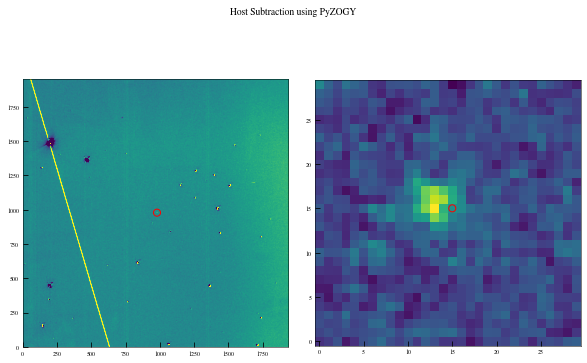

In [19]:
fname = os.path.basename(fpath)
output_dir = dirpath+'_REDUCED/'+fname.replace('.fits','')
host_subtracted_fpath = os.path.join(output_dir,fname.replace('.fits','_APT_image_cutout_subtraction.fits'))

# We will plot out the image 
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize,SquaredStretch,ZScaleInterval


# autophot functions to find image data and header from fits files
from autophot.packages.functions import getimage
from autophot.packages.functions import getheader

# To retrieve the WCS information from this image
from astropy import wcs
from astropy.coordinates import SkyCoord 

# image
data = getimage(host_subtracted_fpath)

# header
header = getheader(host_subtracted_fpath)

# Create an ImageNormalize object
vmin,vmax = (ZScaleInterval(nsamples = 1000)).get_limits(data)

# WCS information of image
w = wcs.WCS(header)

# get pixel coordinates of this source
c = SkyCoord(ra,dec , unit="deg") 
x_pix,y_pix = w.all_world2pix(c.ra.degree, c.dec.degree, 1)

# plot image
fig = plt.figure(figsize = (10,6))

fig.suptitle('Host Subtraction using PyZOGY')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(data,
          vmin = vmin,
          vmax = vmax,
          origin = 'lower',
          cmap = 'viridis')

ax1.scatter(x_pix,y_pix,
            marker = 'o',
            facecolor = 'none',
            edgecolor = 'r',
            s = 50)

# Plot a close up cutout of the source too
cutout_size = 15
cutout = data[int(y_pix-cutout_size):int(y_pix+cutout_size),
              int(x_pix-cutout_size):int(x_pix+cutout_size)]

ax2.imshow(cutout,
           origin = 'lower',
           cmap = 'viridis')

ax2.scatter(cutout_size,cutout_size,
            marker = 'o',
            facecolor = 'none',
            edgecolor = 'r',
            s = 50)
plt.show()


<div class="alert alert-success">
  <strong>Success!</strong> Again AT2018cow is well isolated.
</div>
